In [2]:
import tensorflow as tf
import sys
sys.path.append('/nas/longleaf/home/siyangj/NiftyNet/')
import niftynet as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
import nibabel as nib

INFO:tensorflow:TensorFlow version 1.9.0
CRITICAL:tensorflow:Optional Python module cv2 not found, please install cv2 and retry if the application fails.
INFO:tensorflow:Available Image Loaders:
['nibabel', 'skimage', 'pillow', 'simpleitk', 'dummy'].


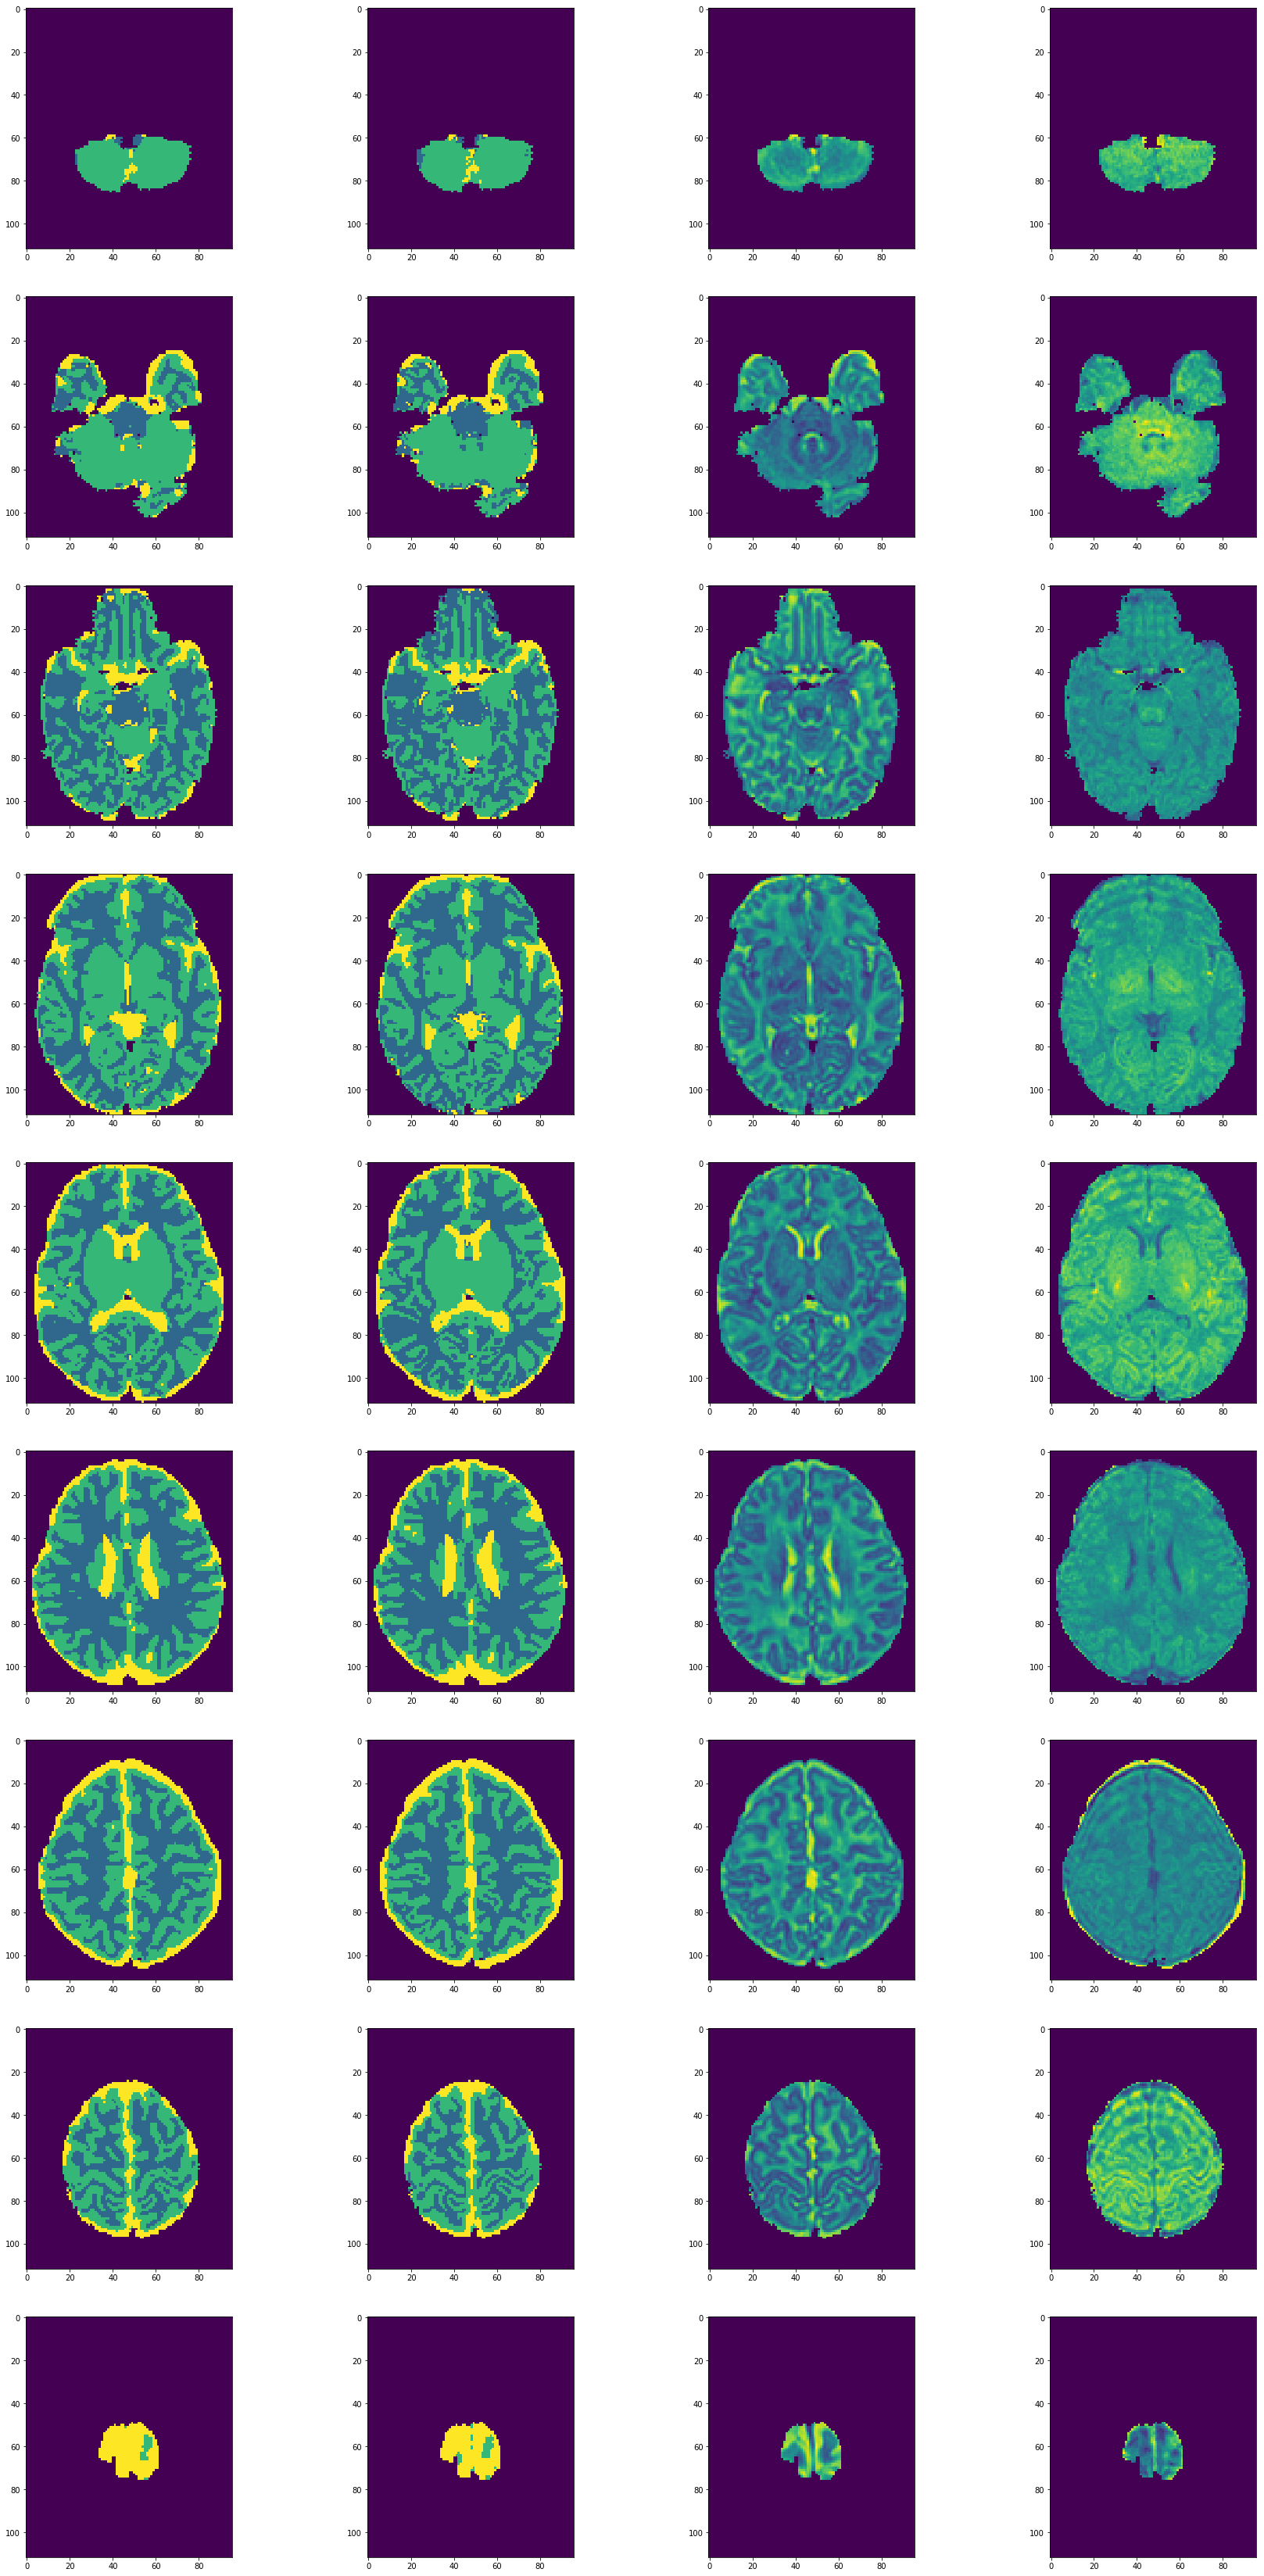

In [5]:
model_num = '10112055'
flip = False
old_format = False
img_num = 3
data_folder = 'min_normal'

inference_iter = '_21900_normal'

seg_suffix = 'seg_inf_1/'

suffix = ('','')
if flip:
    suffix[0] = 'flip'
    suffix[1] = '-flip'

data_path = '/proj/NIRAL/users/siyangj/NeonateMRISeg/TrainigData/'
normal_path = '/proj/NIRAL/users/siyangj/myData/normal/'
if old_format:
    inf_path = '/proj/NIRAL/users/siyangj/unet_{}/{:d}{}_niftynet_out.nii.gz'.format(model_num,img_num,suffix[0])
else:
    inf_path = '/proj/NIRAL/users/siyangj/model_{}/inference{}/{:d}{}_niftynet_out.nii.gz'.format(model_num,
                                                                                        inference_iter,
                                                                                        img_num,suffix[0])
    
seg_path = '/proj/NIRAL/users/siyangj/myData/{}/{}{:d}{}.nrrd'.format(data_folder,
                                                                      seg_suffix,img_num,suffix[1])
T2_path = '/proj/NIRAL/users/siyangj/myData/{}/T2/{:d}{}.nrrd'.format(data_folder,img_num,suffix[1])
T1_path = '/proj/NIRAL/users/siyangj/myData/{}/T1/{:d}{}.nrrd'.format(data_folder,img_num,suffix[1])

img3 = nib.load(inf_path)
img3_arr = np.swapaxes(img3.get_fdata().squeeze(),0,2)

seg3 = sitk.GetArrayFromImage(sitk.ReadImage(seg_path)).squeeze()
T23 = sitk.GetArrayFromImage(sitk.ReadImage(T2_path)).squeeze()
T13 = sitk.GetArrayFromImage(sitk.ReadImage(T1_path)).squeeze()

i = 70
js = [10,20,30,40,50,60,70,80,90]
jlength = len(js)

f,axes = plt.subplots(jlength,4,figsize=(30,60))

for i in np.arange(jlength): 
    axes[i][0].imshow(img3_arr[js[i],:,:])
    axes[i][1].imshow(seg3[js[i],:,:])
    axes[i][2].imshow(T23[js[i],:,:])
    axes[i][3].imshow(T13[js[i],:,:])

In [ ]:
m = sitk.ReadImage(inf_path)
a = sitk.GetArrayFromImage(m)
a.shape

In [10]:
im_num = np.arange(1,9)
suf1 = ['','-flip']
suf2 = {'-seg':'seg/','-T1-stripped':'T1/','-T2-stripped':'T2/'}
cur_dim = np.array([130,140,120])
tar_dim = np.array([136,144,120])
dif_dim = tar_dim - cur_dim
haf_dim = tar_dim / 2

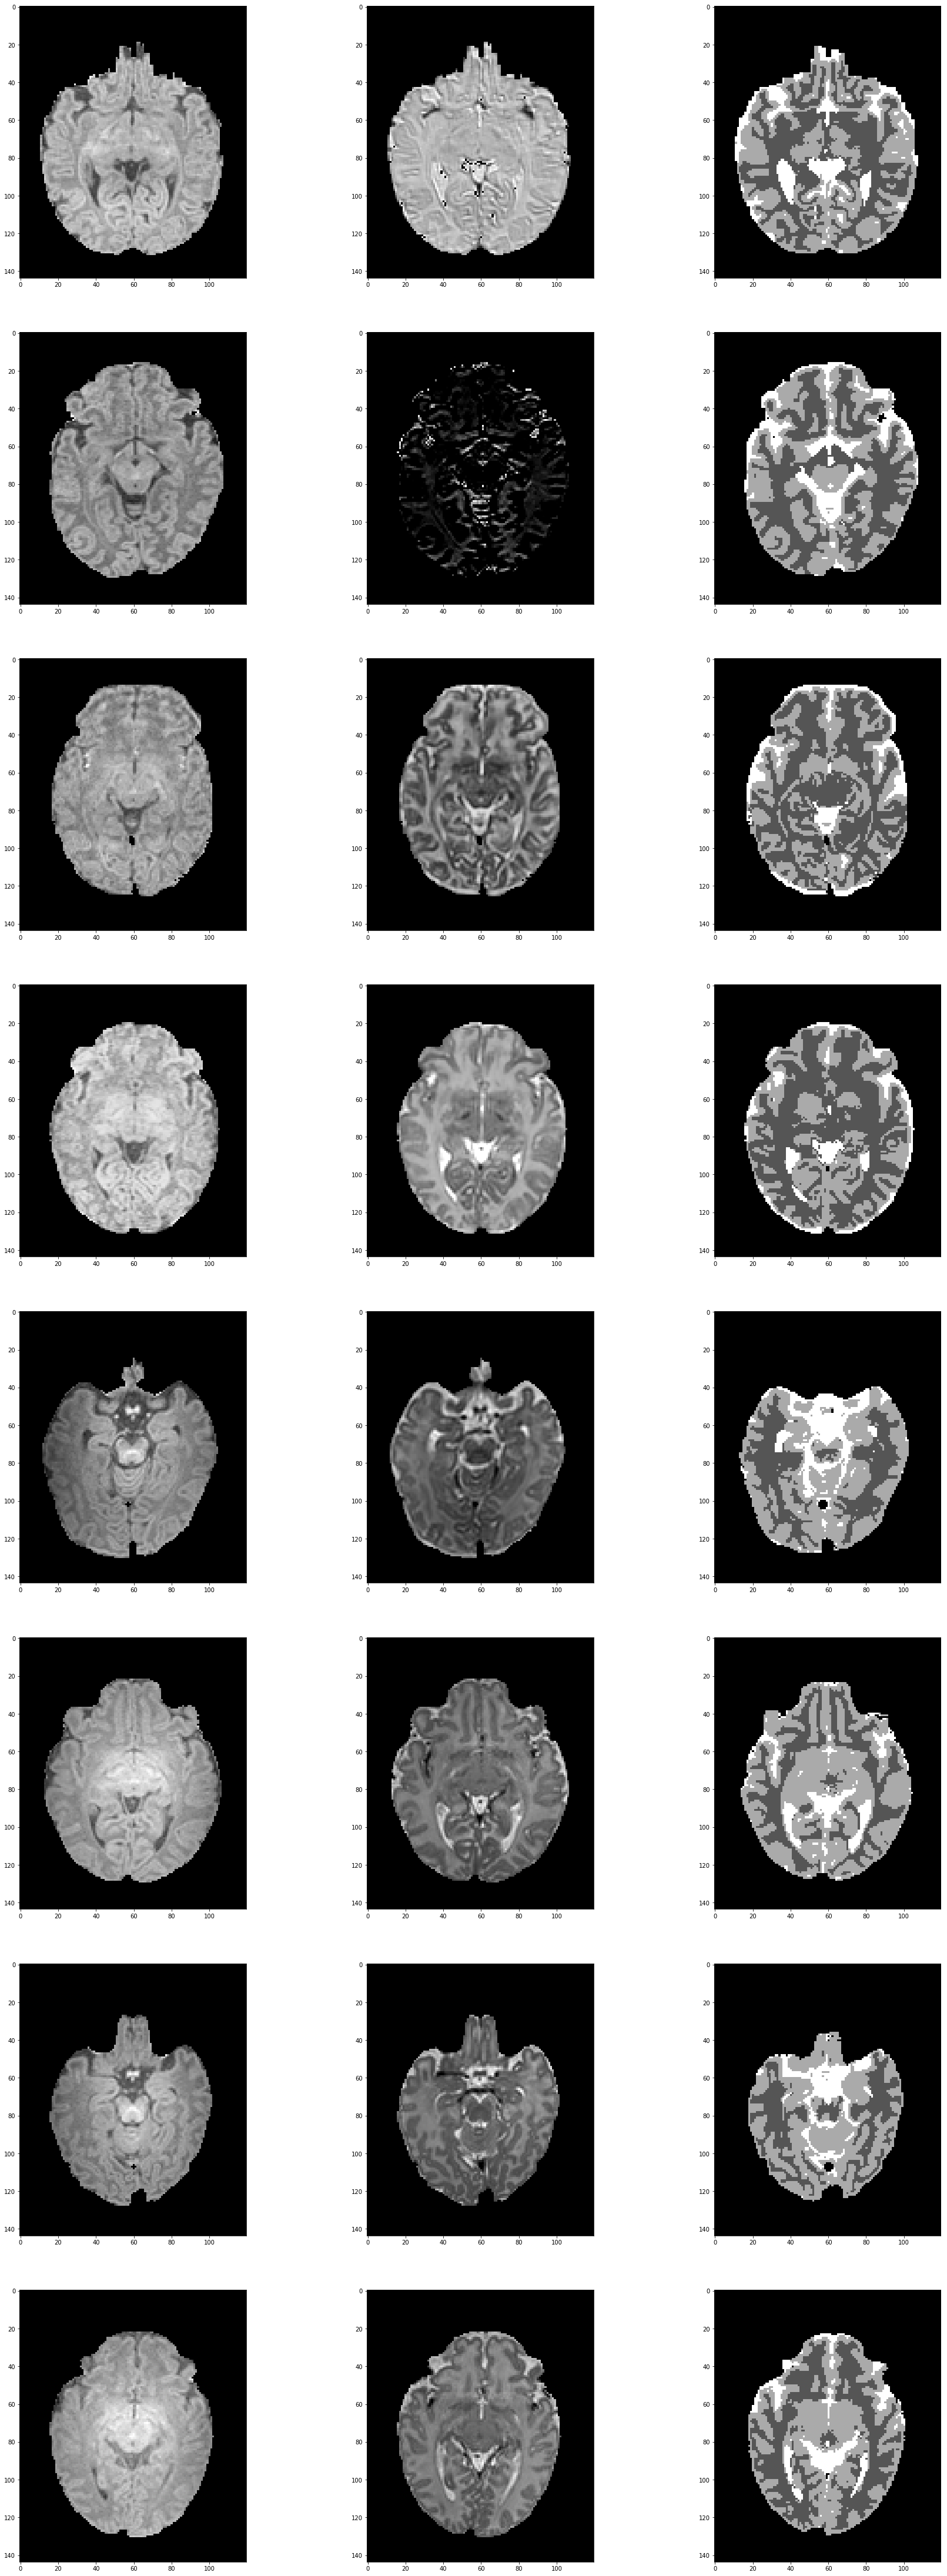

In [5]:
f,axes = plt.subplots(8,3,figsize=(30,80))

slice_num = 60
for i in im_num:
    for s in suf1[0:]:
        im_T1 = sitk.ReadImage(normal_path+'T1/'+str(i)+s+'.nrrd')
        im_T2 = sitk.ReadImage(normal_path+'T2/'+str(i)+s+'.nrrd')
        im_seg = sitk.ReadImage(normal_path+'seg/'+str(i)+s+'.nrrd')
        axes[i-1][0].imshow(sitk.GetArrayFromImage(im_T1)[slice_num,:,:],cmap='gray')
        axes[i-1][1].imshow(sitk.GetArrayFromImage(im_T2)[slice_num,:,:],cmap='gray')
        axes[i-1][2].imshow(sitk.GetArrayFromImage(im_seg)[slice_num,:,:],cmap='gray')

In [5]:
import sys
niftynet_path = '../../'
sys.path.append(niftynet_path)


from niftynet.io.image_reader import ImageReader
from niftynet.contrib.dataset_sampler.sampler_uniform_v2 import UniformSampler
from niftynet.layer.pad import PadLayer
from niftynet.layer.rand_elastic_deform import RandomElasticDeformationLayer
from niftynet.layer.mean_variance_normalisation import MeanVarNormalisationLayer
from niftynet.layer.rand_flip import RandomFlipLayer


def create_image_reader(num_controlpoints, std_deformation_sigma):
    # creating an image reader.
    data_param = \
        {'T1': {'path_to_search': normal_path+'T1/', 
                'filename_contains': '',
                'loader': 'simpleitk'},
         'T2': {'path_to_search': normal_path+'T2/', 
                'filename_contains': '',
                'loader': 'simpleitk'},
         'label': {'path_to_search': normal_path+'seg/', 
                'filename_contains': '',
                'loader': 'simpleitk',
                'interp_order' : 0}
        }
    reader = ImageReader().initialise(data_param)

    #reader.add_preprocessing_layers(MeanVarNormalisationLayer(image_name = 'T1'))
    #reader.add_preprocessing_layers(MeanVarNormalisationLayer(image_name = 'T2'))

    reader.add_preprocessing_layers(PadLayer(
                     image_name=['T1','T2','label'],
                     border=(16,16,16),
                     mode='symmetric'
    )) 

    reader.add_preprocessing_layers(RandomElasticDeformationLayer(
                     num_controlpoints=num_controlpoints,
                     std_deformation_sigma=std_deformation_sigma,
                     proportion_to_augment=1,
                     spatial_rank=2)) 
    
#     reader.add_preprocessing_layers(RandomFlipLayer(
#                  flip_axes=(0,1))) 

    return reader



In [6]:
std_sigma = 25
reader = create_image_reader(6, std_sigma)
_, image_data, _ = reader(1)

INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]


In [23]:
_, image_data, _ = reader(1)

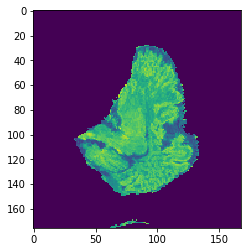

In [24]:
plt.imshow(image_data['T1'].squeeze()[80,:,:])

In [45]:
np.shape(image_data['T1'].squeeze())

(152, 176, 168)

INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: lo

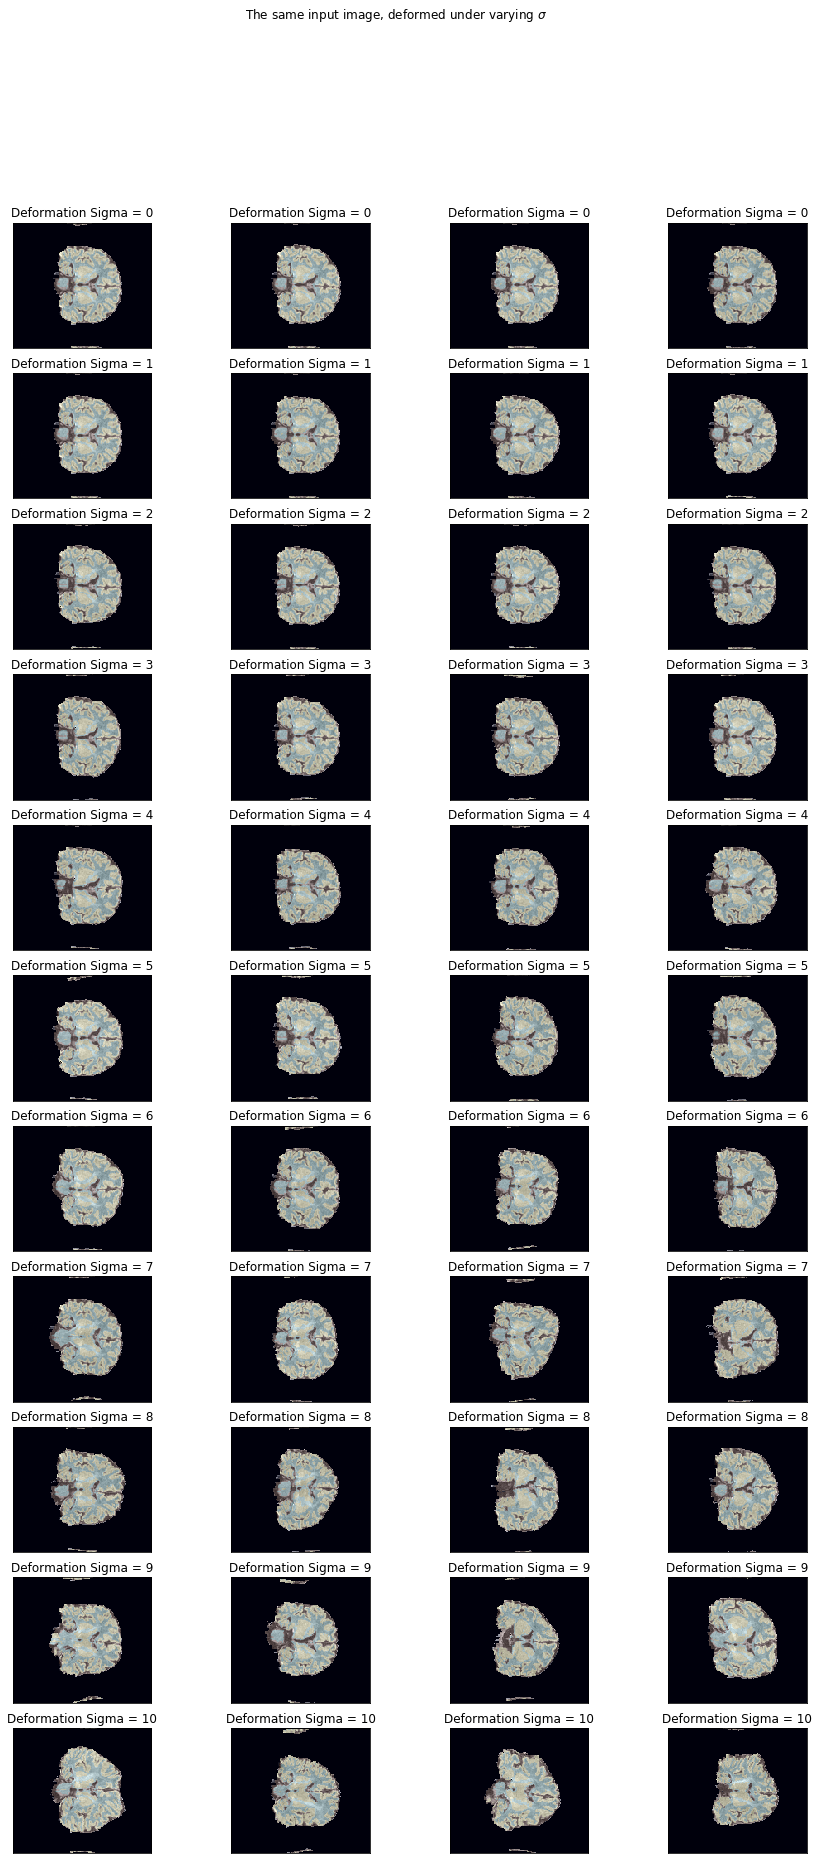

In [28]:
f, axes = plt.subplots(11,4,figsize=(15,30))
f.suptitle('The same input image, deformed under varying $\sigma$')

for i, axe in enumerate(axes): 
    std_sigma = i
    reader = create_image_reader(6, std_sigma)
    for ax in axe: 
        _, image_data, _ = reader(1)
        ax.imshow(image_data['T1'].squeeze()[:,80,:], cmap='gray')
        ax.imshow(image_data['label'].squeeze()[:,80,:], cmap='jet', alpha=0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Deformation Sigma = %i' % std_sigma)


INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: lo

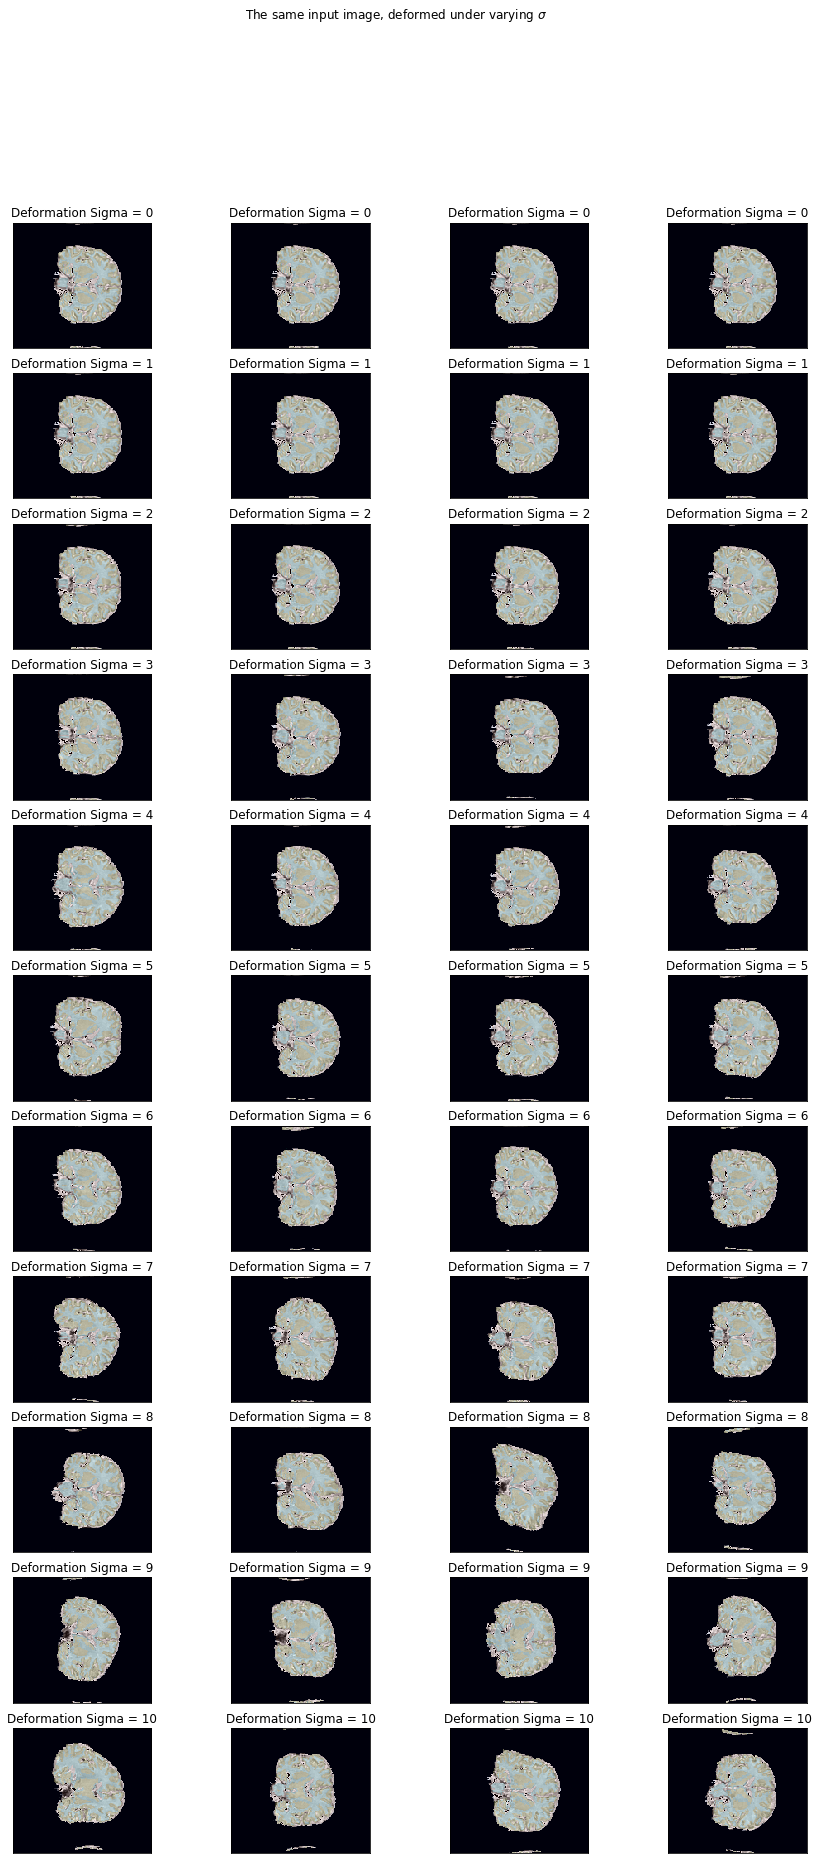

In [29]:
f, axes = plt.subplots(11,4,figsize=(15,30))
f.suptitle('The same input image, deformed under varying $\sigma$')

for i, axe in enumerate(axes): 
    std_sigma = i
    reader = create_image_reader(6, std_sigma)
    for ax in axe: 
        _, image_data, _ = reader(1)
        ax.imshow(image_data['T2'].squeeze()[:,80,:], cmap='gray')
        ax.imshow(image_data['label'].squeeze()[:,80,:], cmap='jet', alpha=0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Deformation Sigma = %i' % std_sigma)

To my eyes, 50 seems about the right number: some significant deformation (images look quite different) but without much in the way of distorting the cells beyond recognisability (like in $\sigma=100$).

## Inference

```diff
[INFERENCE]
-border = (0, 0, 1)
+border = (92, 92, 0)  # please note the zero-entry in the last dimension. 
-#inference_iter = 10
+inference_iter = -1 # use last available checkpoint for inference
-save_seg_dir = ./output/toy
+save_seg_dir = ./output
output_interp_order = 0
-spatial_window_size = (0, 0, 3)
+spatial_window_size = (572, 572, 1)
```

These changes all relate to the specific requirements of 2-d U-Net.


## Finishing the config file: 

We just have to tell the network the final details. 

```diff
[SEGMENTATION]
-image = modality1
+image = cells
label = label
+weight = xent_weights
output_prob = False
-num_classes = 160
+num_classes = 2
-label_normalisation = True
+label_normalisation = False

```

`label normalisation` is unnecessary, as we already binarised the labels ourselves. Apart from that, this is a case of telling the `segmentation` application how to use the data we've specified. 

<a id="exp"></a>

# The Experiments: 


Although there are many experiments you could do, I will do a simple one: 

Which augmentation methods lead to the best performance of the segmentation tool? 

To do this, I will vary the augmentation: I will either do: 

1. no augmentation (baseline) 
2. random flips 
3. elastic deformation 
4. flips + deformation 

To do this, I will create similar `.ini` files, with difference augmentation options and `model_dir` parameter. 

You can see the approach I took to do this in the file `/demos/unet/generate_run_commands.py`. Here, I programmatically generate different test conditions. I do this by using the fact that command line options override any options specified in the `.ini` files, so I can use one common `.ini` file as long as I specify a different `model_dir`. 

## The train/test split: 

Each experiment has only 2 sets of data, with some number of labeled images for each. I will therefore do a 2-fold cross-validation: using only one set of the data, I will try to predict the results for the other. 

I thus have one further option to give to the `.ini` file: in `[SYSTEM]`, I will set the `dataset_split_file` option.


## Commands for the command line: 

By running the file, I show here an example of the command line commands I will use. 

```
python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_0

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_1

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_2

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_3

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_4

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_5

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_6

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_7
```


<a id="tb"></a>

## Monitoring during training

NiftyNet, by default, tracks training progress. To see this, use a command like: `tensorboard --logdir models`. 

I used this to choose a minimal point for the `Validation` set to do the inference. 

The commands for inference are similar to aboce, except `train` is replaced by `inference` and I set the `--inference_iter` parameter depending on the training curves.

<a id="results"></a>

## Looking at Results: 

In this section, we will look at the results from these various experiments. I have made a few functions here, to show the model outputs (a useful sense-check) and collate the results in a tabular form. 

There are several helper functions I've written here for this specific task.


In [6]:
%load_ext autoreload
%autoreload(1)
from unet_demo_utils import * 

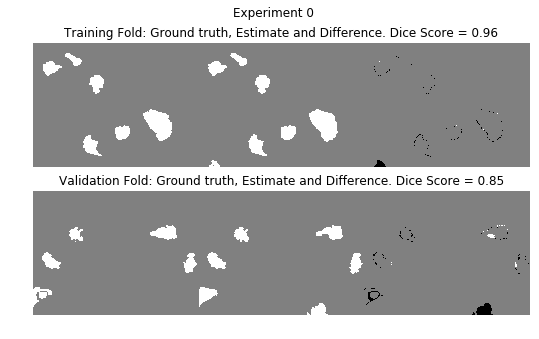

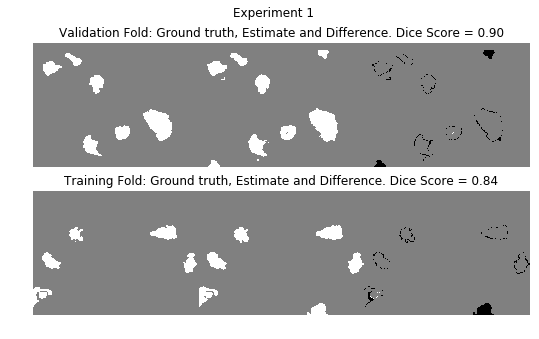

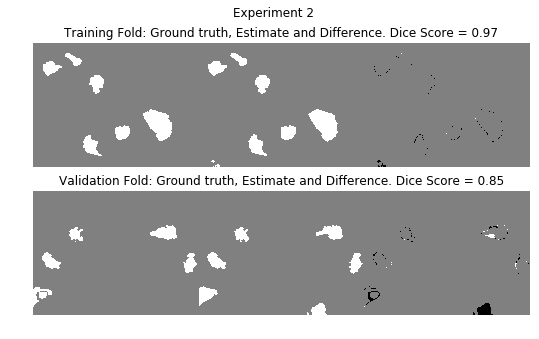

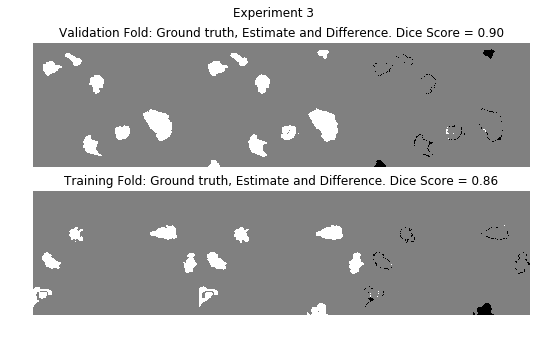

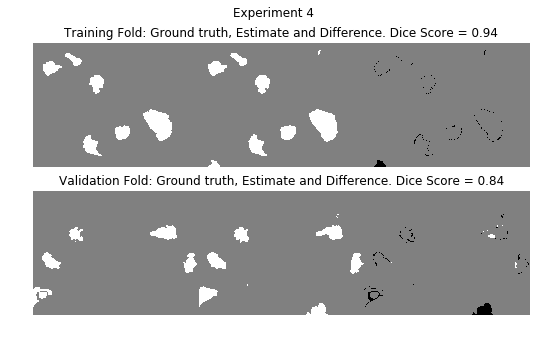

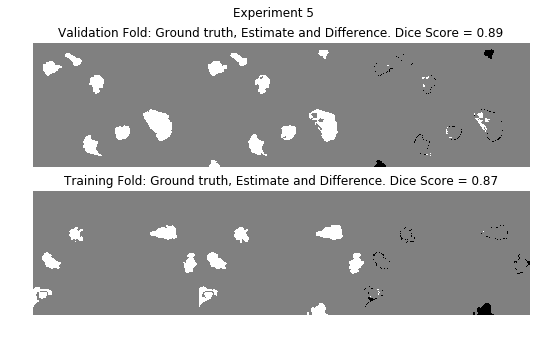

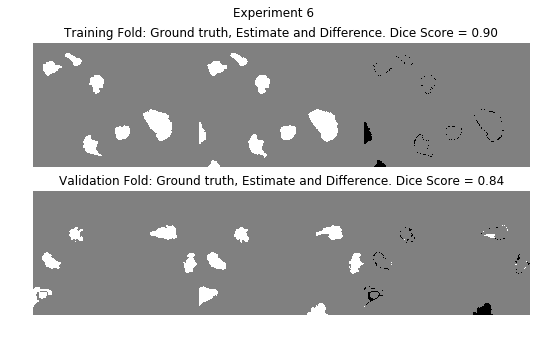

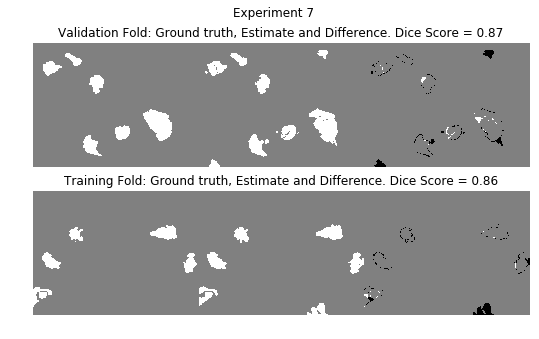

In [7]:
data_dir = "../../data/u-net/PhC-C2DH-U373/niftynet_data/"

u373_ground_truths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('bin_seg')]
est_dirs = {x: "../../models/U373_" + str(x) + "/output/" for x in range(8)}
u373_ids = ('001_01', '059_02')

df_u373 = get_and_plot_results(u373_ground_truths, est_dirs, u373_ids)
    


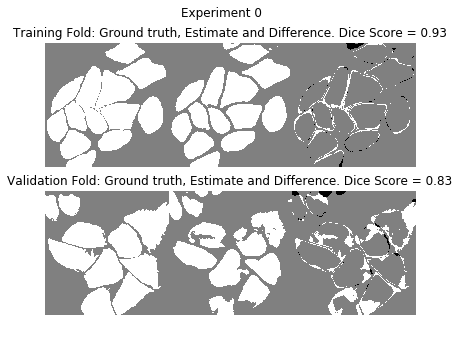

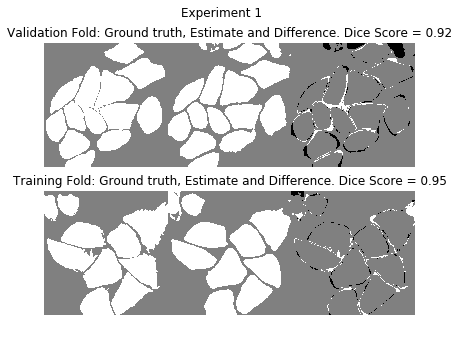

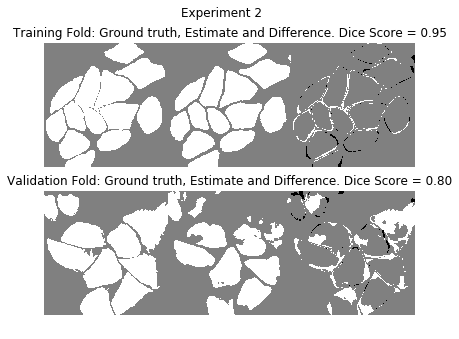

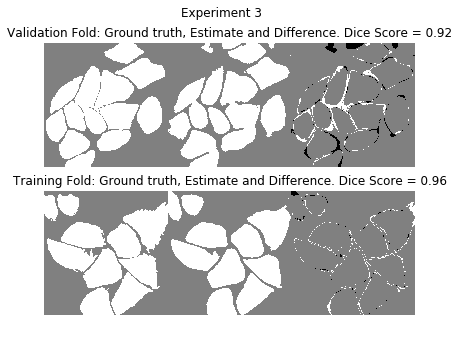

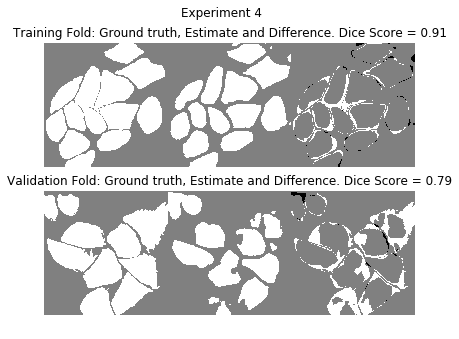

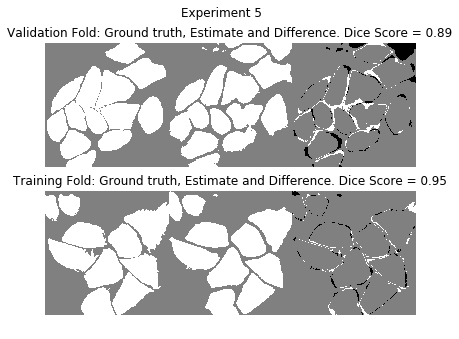

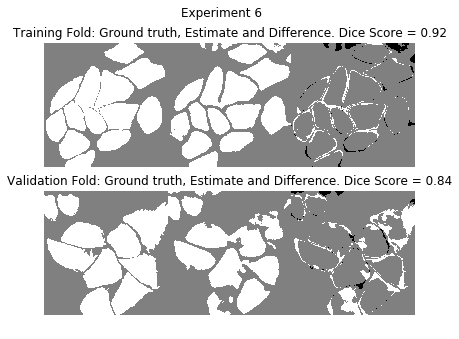

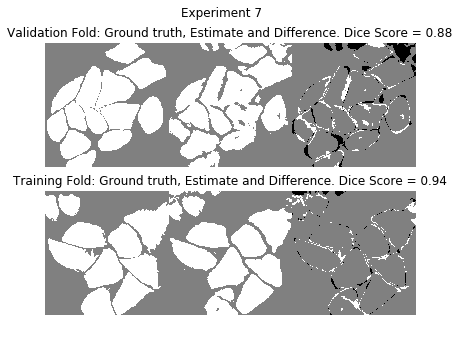

In [8]:
data_dir = "../../data/u-net/DIC-C2DH-HeLa/niftynet_data/"

hela_ground_truths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('bin_seg')]
est_dirs = {x: "../../models/HeLa_" + str(x) + "/output/" for x in range(8)}

hela_ids = ('039_01', '034_02')

df_hela = get_and_plot_results(hela_ground_truths, est_dirs, hela_ids)


Text(0.5,1,'Dice score for HeLa data')

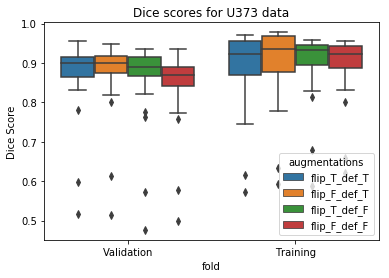

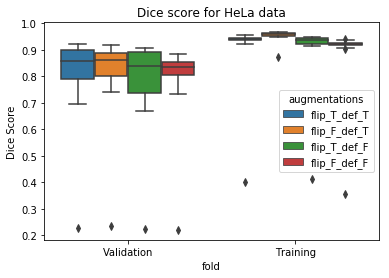

In [9]:
f, ax = plt.subplots()
sns.boxplot('fold', 'value', data=df_u373, hue='augmentations', ax=ax)
ax.set_ylabel('Dice Score')
ax.set_title('Dice scores for U373 data')

f, ax = plt.subplots()
sns.boxplot('fold', 'value', data=df_hela, hue='augmentations', ax=ax)
ax.set_ylabel('Dice Score')
ax.set_title('Dice score for HeLa data')



In [10]:
print('Mean scores for validation on U373: Paper gets 0.9203')

for meth in np.unique(df_u373['augmentations']):
    print(meth, df_u373[(df_u373['fold']=='Validation') & (df_u373['augmentations']==meth)]['value'].mean())

print('Mean scores for validation on HeLa: Paper gets 0.7756')
for meth in np.unique(df_hela['augmentations']):
    print(meth, df_hela[(df_hela['fold']=='Validation') & (df_hela['augmentations']==meth)]['value'].mean())


Mean scores for validation on U373: Paper gets 0.9203
flip_F_def_F 0.8473459917119964
flip_F_def_T 0.876098366581922
flip_T_def_F 0.8656362831535208
flip_T_def_T 0.876622324210172
Mean scores for validation on HeLa: Paper gets 0.7756
flip_F_def_F 0.7927651375180577
flip_F_def_T 0.8153034423789014
flip_T_def_F 0.7886978570433607
flip_T_def_T 0.8140490489143175


<a id="analysis"></a>

### Analysing the results: 

We have performed a two-fold cross-validation for each of the datasets presented. The segmentations look similar to the ground truth. One difference is that the estimations tend to highlight regions that are not in the ground truth. This may be because the labels for the Cell Tracking Challenge are not complete (this was part of the challenge). 

Comparing our results to the results in the U-Net paper, we should remember that we've used only half of the training data for validating the results. Thus, our scores should be lower than on the challenge. 

However, we did not go through the final steps of the challenge: giving the 'blobs' different labels and making sure that touching blobs were resolved as two separate cells. This means that our score for the HeLa results is going to be too high. 

Looking above at the results, we are in the ballpark of the published results. 

In terms of augmentations, while there is not that much data, using deformations does seem to improve on the baseline of 'no augmentations'. It is not clear if flipping helps if you're also using deformations. 


### Possible extensions: 

Were I to continue this investigation, I may look into different labelling of the training images. The HeLa results seem to be under-segmented, staying away from the highly-weighted gaps between cells. It may be possible to use a different labelling to avoid this (for instance, labelling the borders with a separate class label).

### Wrapping up: 

We have gone through how to do an experimental pipeline in NiftyNet, based on the experiments in the U-Net paper. While we have produced a lot of data and done a lot of work, the key components in the experiments were determined in the `config` files. By using command-line arguments to NiftyNet, we geenerated several experimental conditions. Finally, we generated and analysed the resulting data. 

<a id="refs"></a>
### References


[1] Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[2] Gibson, E., Li, W., Sudre, C., Fidon, L., Shakir, D., Wang, G., Eaton-Rosen, Z., Gray, R., Doel, T., Hu, Y. and Whyntie, T., 2017. NiftyNet: a deep-learning platform for medical imaging. arXiv preprint arXiv:1709.03485.


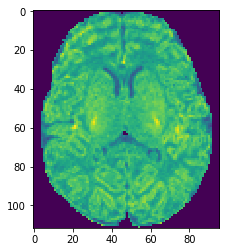

In [12]:
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage('/proj/NIRAL/users/siyangj/myData/min_normal/T1/3.nrrd'))[50,:,:])